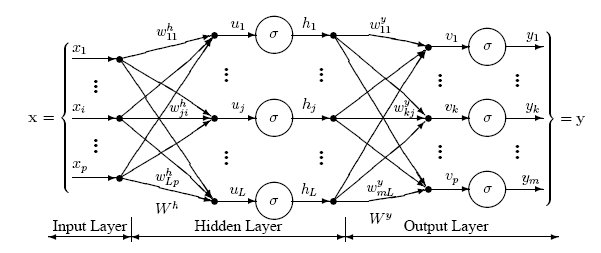

# 1. Business Understanding


**About the dataset**

  - Business licenses issued by the Department of Business Affairs and Consumer Protection in the City of Chicago.

- Data fields requiring description are detailed below:

  **APPLICATION TYPE**:
    - *ISSUE* is the record associated with the initial license application.
    - *RENEW* is a subsequent renewal record. All renewal records are created with a term start date and term expiration date.
    - *C_LOC* is a change of location record. It means the business moved.
    - *C_CAPA* is a change of capacity record. Only a few license types may file this type of application.
    - *C_EXPA* only applies to businesses that have liquor licenses. It means the business locationexpanded    

- **LICENSE STATUS**
  - *AAI* means the license was issued.
  - *AAC* means the license was cancelled during its term
  - *REV* means the license was revoked
  - *REA* means the license revocation has been appealed.
  - *LICENSE STATUS CHANGE DATE* This date corresponds to the date a license was cancelled (AAC), revoked (REV) or appealed (REA).




- **Objective Definition**  
  - To assess if a customer's license should be issued(AAI), renewed(REV) or cancelled(AAC) depending on various parameters
  - Learn from various features of applications rejected or given in the past to come up with a decision
  - Developing a multi classification system to predict whether a new business-license application will be “cancelled (AAC)” vs. not cancelled.  
  - Emphasis on early detection so that the Business Affairs Team can proactively review high-risk cases.


- **Stakeholder Analysis**  
  - **Business Affairs Team**: Requires timely alerts on high-risk applications.  
  - **Data Engineers**: Responsible for maintaining and monitoring ingestion pipelines and model-retraining schedules.  
  - **Business Owners / Analysts**: Need interpretable model outputs and clear success criteria.

- **Success Metrics**  
  - **Overall Accuracy** ≥ 95%  
  - **Recall on AAC class** ≥ 90% (maximize true positives for cancellations)  
  - **Precision on AAC class** ≥ 50% (limit false positives to reduce analyst workload)  
  - **ROC AUC** ≥ 0.90

#2. Data Wrangling


* **Data source inventory & load**

  * Pointed at `License_Data.csv` on S3 as the single raw table.
  * Streamed via `pd.read_csv()` and checked `df.shape` to catch missing or extra rows/columns early.

* **Automated profiling**

  * `df.info()` for memory, null‐counts & inferred dtypes (to spot mis-typed fields).
  * `df.isna().sum()` to quantify missingness.
  * `df.describe()` to flag numeric outliers.
  * `value_counts()` on key categoricals (e.g. license statuses) to gauge class balance.

* **Display tuning**

  * Enabled full‐column & unlimited‐width views with `pd.set_option` so no truncation during review.

* **Dtype harmonization & performance**

  * **Dates →** `datetime64[ns]` (with `errors='coerce'`) for reliable delta calculations and cycle extractions.
  * **IDs →** cast to `str` (e.g. `ID`, `ACCOUNT_NUMBER`) to block unintended numeric ops.
  * **Binary flags →** mapped `{'Y','YES'}→True`, `{'N','NO'}→False`, filled others `False` for consistent Booleans.
  * **ZIP codes →** filled nulls with `'00000'`, cast to `str` and zero-padded to 5 digits for uniformity.
  * **Target →** converted `LICENSE_STATUS` to `category` to shrink memory & speed group-by.

* **Post-conversion validation**

  * Reviewed `df.dtypes` to confirm every column now has its intended, analysis-friendly type.


In [1]:
import pandas as pd


In [2]:

df = pd.read_csv(
    "https://bubeebkt.s3.amazonaws.com/ds-datasets/License_Data.csv",
    low_memory=False
)

print("Shape:", df.shape)


Shape: (85895, 32)


In [4]:
# 3) Sample 100 rows
sample_raw = df.sample(n=100, random_state=42)

from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/colab_data/sample_raw.csv'
sample_raw.to_csv(save_path, index=False)

print(f"Saved 100-row sample to {save_path}")

Mounted at /content/drive
Saved 100-row sample to /content/drive/MyDrive/colab_data/sample_raw.csv


##Data Profiling

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85895 entries, 0 to 85894
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID                                 85895 non-null  object 
 1   LICENSE_ID                         85895 non-null  int64  
 2   ACCOUNT_NUMBER                     85895 non-null  int64  
 3   SITE_NUMBER                        85895 non-null  int64  
 4   LEGAL_NAME                         85895 non-null  object 
 5   DOING_BUSINESS_AS_NAME             85894 non-null  object 
 6   ADDRESS                            85895 non-null  object 
 7   CITY                               85895 non-null  object 
 8   STATE                              85895 non-null  object 
 9   ZIP_CODE                           85864 non-null  object 
 10  WARD                               36194 non-null  float64
 11  PRECINCT                           29194 non-null  flo

In [ ]:
print(df.isna().sum())


ID                                       0
LICENSE_ID                               0
ACCOUNT_NUMBER                           0
SITE_NUMBER                              0
LEGAL_NAME                               0
DOING_BUSINESS_AS_NAME                   1
ADDRESS                                  0
CITY                                     0
STATE                                    0
ZIP_CODE                                31
WARD                                 49701
PRECINCT                             56701
WARD_PRECINCT                        49700
POLICE_DISTRICT                      54012
LICENSE_CODE                             0
LICENSE_DESCRIPTION                      0
LICENSE_NUMBER                           1
APPLICATION_TYPE                         0
APPLICATION_CREATED_DATE             64660
APPLICATION_REQUIREMENTS_COMPLETE      214
PAYMENT_DATE                          1289
CONDITIONAL_APPROVAL                     0
LICENSE_TERM_START_DATE                228
LICENSE_TER

In [ ]:

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(df.head())


,ID,LICENSE_ID,ACCOUNT_NUMBER,SITE_NUMBER,LEGAL_NAME,DOING_BUSINESS_AS_NAME,ADDRESS,CITY,STATE,ZIP_CODE,WARD,PRECINCT,WARD_PRECINCT,POLICE_DISTRICT,LICENSE_CODE,LICENSE_DESCRIPTION,LICENSE_NUMBER,APPLICATION_TYPE,APPLICATION_CREATED_DATE,APPLICATION_REQUIREMENTS_COMPLETE,PAYMENT_DATE,CONDITIONAL_APPROVAL,LICENSE_TERM_START_DATE,LICENSE_TERM_EXPIRATION_DATE,LICENSE_APPROVED_FOR_ISSUANCE,DATE_ISSUED,LICENSE_STATUS_CHANGE_DATE,SSA,LATITUDE,LONGITUDE,LOCATION,LICENSE_STATUS
0,35342-20020816,1256593,32811,1,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,2625 S CENTRAL PARK AVE 1,CHICAGO,IL,60623.0,22.0,28.0,22-28,10.0,1010,Limited Business License,35342.0,RENEW,NaT,False,2002-08-21,False,2002-08-16,2003-08-15,False,2006-04-11,NaT,25.0,41.843613,-87.714618,"{'latitude': '41.843612879431845', 'longitude': '-87.71461847216574', 'needs_recoding': False, 'human_address': '{""address"":"""",""city"":"""",""state"":"""",""zip"":""""}'}",AAI
1,1358463-20051116,1639294,262311,29,"ISLA TROPICAL, INC.",ISLA TROPICAL,2825 W MONTROSE AVE,CHICAGO,IL,60618,33.0,23.0,33-23,17.0,1315,Mobile Food Dispenser,1358463.0,RENEW,NaT,False,2005-11-03,False,2005-11-16,2006-11-15,False,2006-06-12,2006-06-15,60.0,41.961132,-87.699626,"{'latitude': '41.96113244107215', 'longitude': '-87.69962604438346', 'needs_recoding': False, 'human_address': '{""address"":"""",""city"":"""",""state"":"""",""zip"":""""}'}",AAC
2,1980233-20090722,1980233,345008,1,DJS REMODELING,"DJS REMODELING, INC.",1605 CLAVEY RD 1,HIGHLAND,IL,60035,NaN,NaN,NaN,NaN,1011,Home Repair,1980233.0,ISSUE,2009-06-29,False,2009-07-22,False,2009-07-22,2011-07-15,False,2009-07-22,NaT,NaN,NaN,NaN,NaN,AAI
3,1476582-20040211,1476582,273121,1,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,8 NORTH TRAIL,LEMONT,IL,60439,NaN,NaN,NaN,NaN,1010,Limited Business License,1476582.0,ISSUE,2004-02-10,False,2004-02-10,False,2004-02-11,2005-02-15,False,2004-02-11,NaT,NaN,NaN,NaN,NaN,AAI
4,1141408-20080516,1896750,213785,1,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,4081 JOSEPH DR,WAUKEGAN,IL,60087,NaN,NaN,NaN,NaN,1010,Limited Business License,1141408.0,RENEW,NaT,False,2008-06-04,False,2008-05-16,2010-05-15,False,2008-06-05,NaT,NaN,NaN,NaN,NaN,AAI


## Modifying Data types

In [ ]:

#Parse dates
date_cols = [
    'APPLICATION_CREATED_DATE', 'PAYMENT_DATE',
    'LICENSE_TERM_START_DATE', 'LICENSE_TERM_EXPIRATION_DATE',
    'DATE_ISSUED', 'LICENSE_STATUS_CHANGE_DATE'
]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors='coerce')

#IDs as strings
id_cols = ['ID', 'ACCOUNT_NUMBER', 'LICENSE_NUMBER', 'SITE_NUMBER']
for c in id_cols:
    df[c] = df[c].astype(str)

#Categorical codes
cat_cols = ['LICENSE_CODE', 'WARD', 'PRECINCT', 'POLICE_DISTRICT', 'SSA']
for c in cat_cols:
    df[c] = df[c].astype('category')

#Boolean flags
bool_map = {'Y': True, 'N': False, 'YES': True, 'NO': False}
flag_cols = [
    'APPLICATION_REQUIREMENTS_COMPLETE',
    'CONDITIONAL_APPROVAL',
    'LICENSE_APPROVED_FOR_ISSUANCE'
]
for c in flag_cols:
    df[c] = df[c].map(bool_map).fillna(False)

#zero-padded strings
df['ZIP_CODE'] = df['ZIP_CODE'].fillna('00000').astype(str).str.zfill(5)

#Target as category
df['LICENSE_STATUS'] = df['LICENSE_STATUS'].astype('category')

#Check dtypes
print(df.dtypes)


ID                                           object
LICENSE_ID                                    int64
ACCOUNT_NUMBER                               object
SITE_NUMBER                                  object
LEGAL_NAME                                   object
DOING_BUSINESS_AS_NAME                       object
ADDRESS                                      object
CITY                                         object
STATE                                        object
ZIP_CODE                                     object
WARD                                       category
PRECINCT                                   category
WARD_PRECINCT                                object
POLICE_DISTRICT                            category
LICENSE_CODE                               category
LICENSE_DESCRIPTION                          object
LICENSE_NUMBER                               object
APPLICATION_TYPE                             object
APPLICATION_CREATED_DATE             datetime64[ns]
APPLICATION_

<ipython-input-3-c457dfce60ae>:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].map(bool_map).fillna(False)
<ipython-input-3-c457dfce60ae>:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].map(bool_map).fillna(False)


In [ ]:
print(df.LICENSE_STATUS.value_counts())

LICENSE_STATUS
AAI    55400
AAC    30200
REV      290
REA        3
INQ        2
Name: count, dtype: int64


# 3. EDA (Exploratory Data Analysis)


* ## Categorical Relationship Analysis via Normalized Crosstab

  * Normalize counts of `APPLICATION_TYPE` vs `LICENSE_STATUS` to proportions
  * **Why:** Surfaces which application categories have disproportionately high rejection or inquiry rates, guiding targeted interventions

* ## Spatial Distribution Scatter Plot

  * Plot geocoded `latitude`/`longitude` colored by `LICENSE_STATUS` on equal‐scaled axes
  * **Why:** Detects geographic clusters or anomalies in approvals vs. revocations, and flags potential geocoding errors

* ## Top-N Location Frequency Bars

  * Bar charts of the 30 most frequent `CITY` and `STATE` values
  * **Why:** Reveals regional concentration and sampling bias, informing stratified modeling or location-based features

* ## Stacked Bar of Application Type vs Status

  * Counts of each (`APPLICATION_TYPE`, `LICENSE_STATUS`) combination plotted as stacked bars with consistent ordering
  * **Why:** Compares absolute and relative outcome distributions across application types at a glance

* ## License Description Cardinality and Distribution

  * `value_counts()` for `LICENSE_DESCRIPTION`, top 30 categories in a bar chart
  * **Why:** Highlights dominant vs. long-tail license types, informing grouping or embedding strategies

* ## Temporal Trend Analysis of Application vs Issuance Dates

  * Convert `APPLICATION_CREATED_DATE` & `DATE_ISSUED` to datetimes, plot daily counts over time
  * **Why:** Exposes seasonality, processing lag, and anomalous spikes or data gaps

* ## Missingness Audit

  * Compute per-column null counts, sort descending
  * **Why:** Prioritizes features for imputation, removal, or special handling based on missingness

* ## Feature Cardinality Check

  * Count unique values per column, distinguish low vs. high cardinality features
  * **Why:** Informs encoding strategy (one-hot vs. hashing/embeddings) and flags identifier-like columns for exclusion


In [ ]:
# Relationship between APPLICATION_TYPE vs LICENSE_STATUS
ct = pd.crosstab(df.LICENSE_STATUS, df.APPLICATION_TYPE, normalize="columns")
display(ct)

APPLICATION_TYPE,C_CAPA,C_EXPA,C_LOC,ISSUE,RENEW
LICENSE_STATUS,,,,,
AAC,1.0,0.6,0.205000,0.338320,0.359941
AAI,0.0,0.0,0.794286,0.659244,0.636212
INQ,0.0,0.0,0.000000,0.000085,0.000000
REA,0.0,0.0,0.000000,0.000000,0.000049
REV,0.0,0.4,0.000714,0.002351,0.003798


## Location vs Applictaion Status

In [ ]:
import matplotlib.pyplot as plt

# Filter out
map_df = df.dropna(subset=['LATITUDE', 'LONGITUDE', 'LICENSE_STATUS'])

# Define the order
status_order = ['AAC', 'AAI', 'INQ', 'REA', 'REV']
colors = ['green', 'lime', 'yellow', 'orange', 'red']
color_map = dict(zip(status_order, colors))



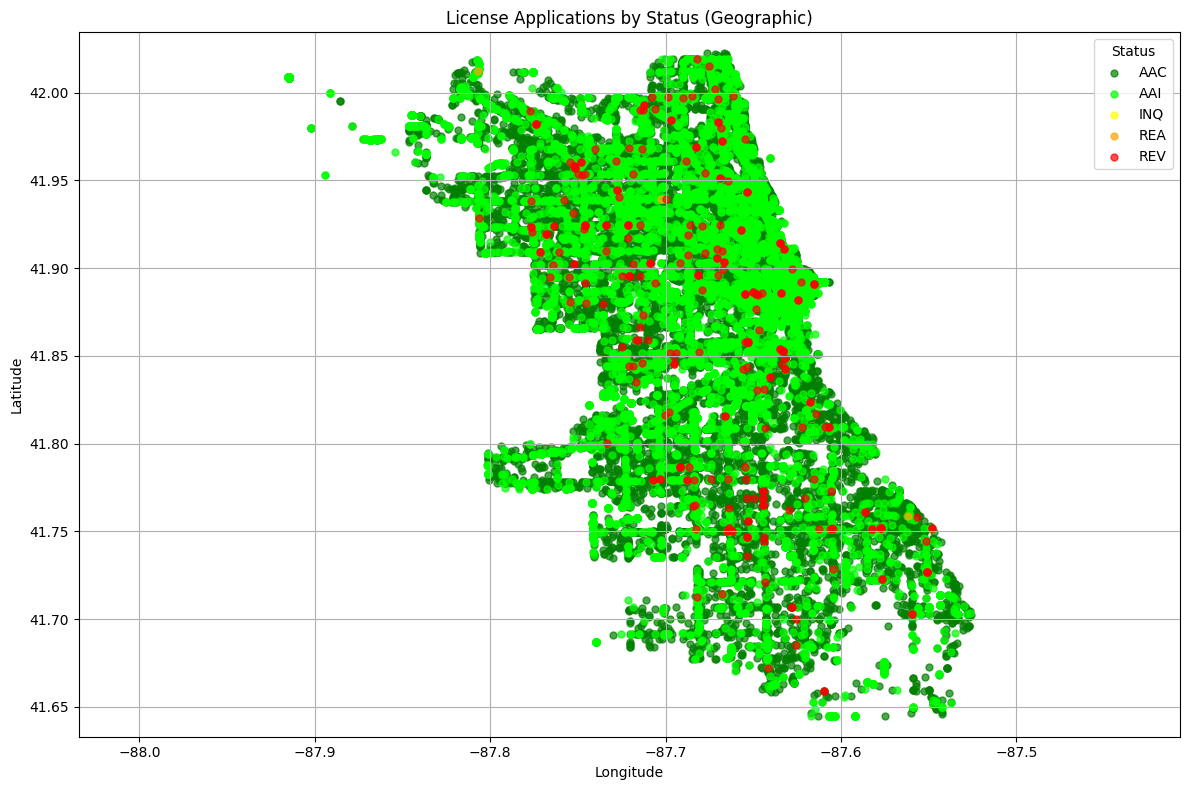

In [ ]:
plt.figure(figsize=(12, 8))
for status in status_order:
    pts = map_df[map_df['LICENSE_STATUS'] == status]
    plt.scatter(
        pts['LONGITUDE'],
        pts['LATITUDE'],
        s=25,
        alpha=0.7,
        label=status,
        color=color_map[status]
    )

plt.title('License Applications by Status (Geographic)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Status')
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()

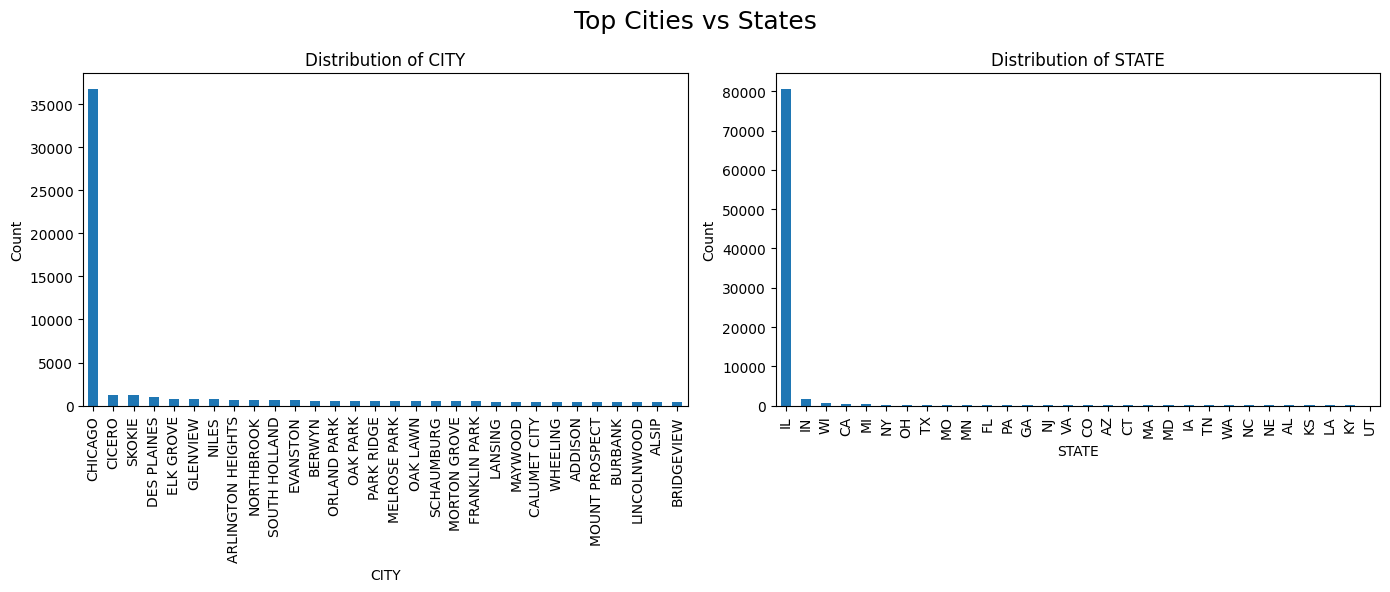

In [ ]:

cols = ['CITY', 'STATE']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Top Cities vs States', fontsize=18)

for ax, col in zip(axes, cols):
    df[col].value_counts().head(30).plot(kind='bar', ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()


<ipython-input-25-9e4a9228dbae>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([type_col, status_col]).size().unstack(fill_value=0)


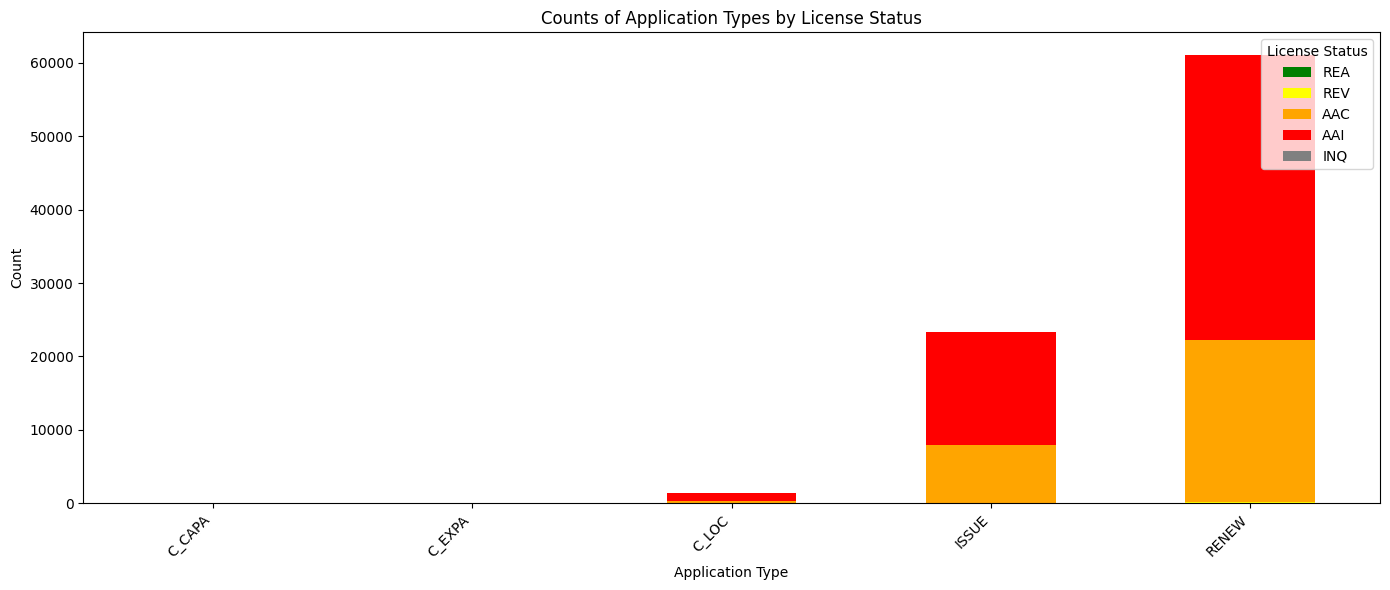

In [ ]:
status_col = 'LICENSE_STATUS'
type_col   = 'APPLICATION_TYPE'
counts = df.groupby([type_col, status_col]).size().unstack(fill_value=0)

ordered_statuses = ['REA', 'REV', 'AAC', 'AAI', 'INQ']
counts = counts.reindex(columns=ordered_statuses, fill_value=0)

color_map = {
    'REA': 'green',
    'REV': 'yellow',
    'INQ': 'grey',
    'AAC': 'orange',
    'AAI': 'red'
}
colors = [color_map[s] for s in counts.columns]

fig, ax = plt.subplots(figsize=(14, 6))
counts.plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=ax
)

ax.set_xlabel('Application Type')
ax.set_ylabel('Count')
ax.set_title('Counts of Application Types by License Status')
ax.legend(title='License Status', loc='upper right')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

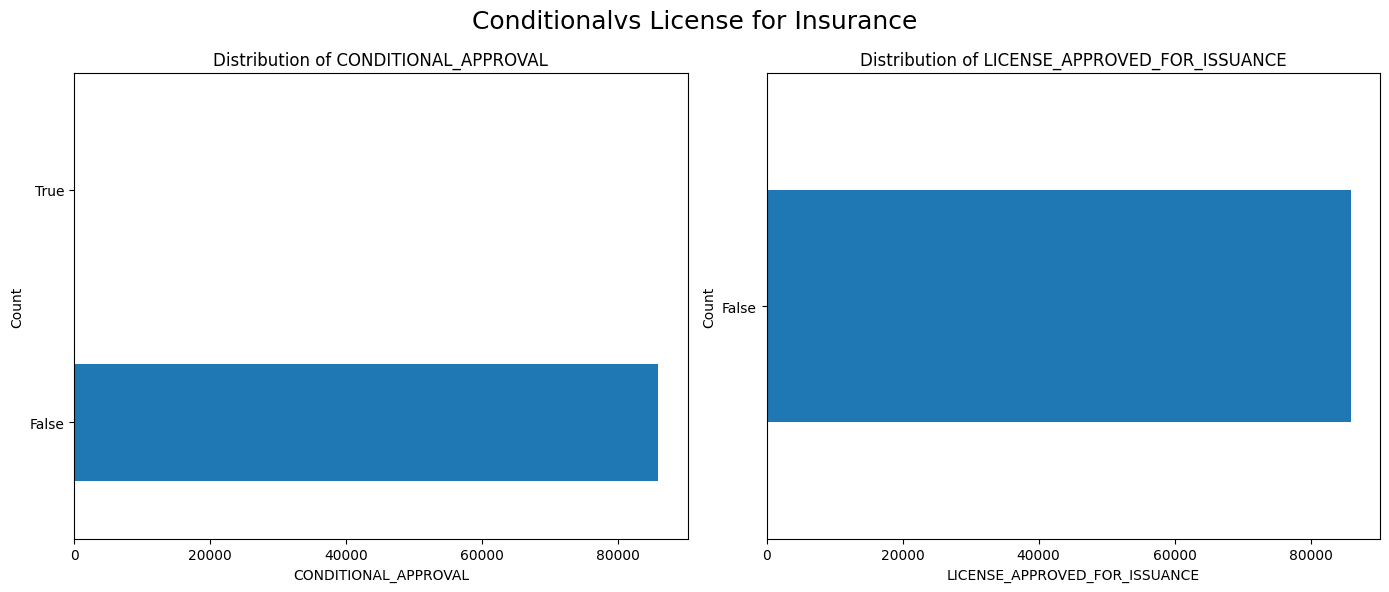

In [ ]:

cols = ['CONDITIONAL_APPROVAL', 'LICENSE_APPROVED_FOR_ISSUANCE']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Conditionalvs License for Insurance', fontsize=18)

for ax, col in zip(axes, cols):
    df[col].value_counts().head(30).plot(kind='barh', ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()


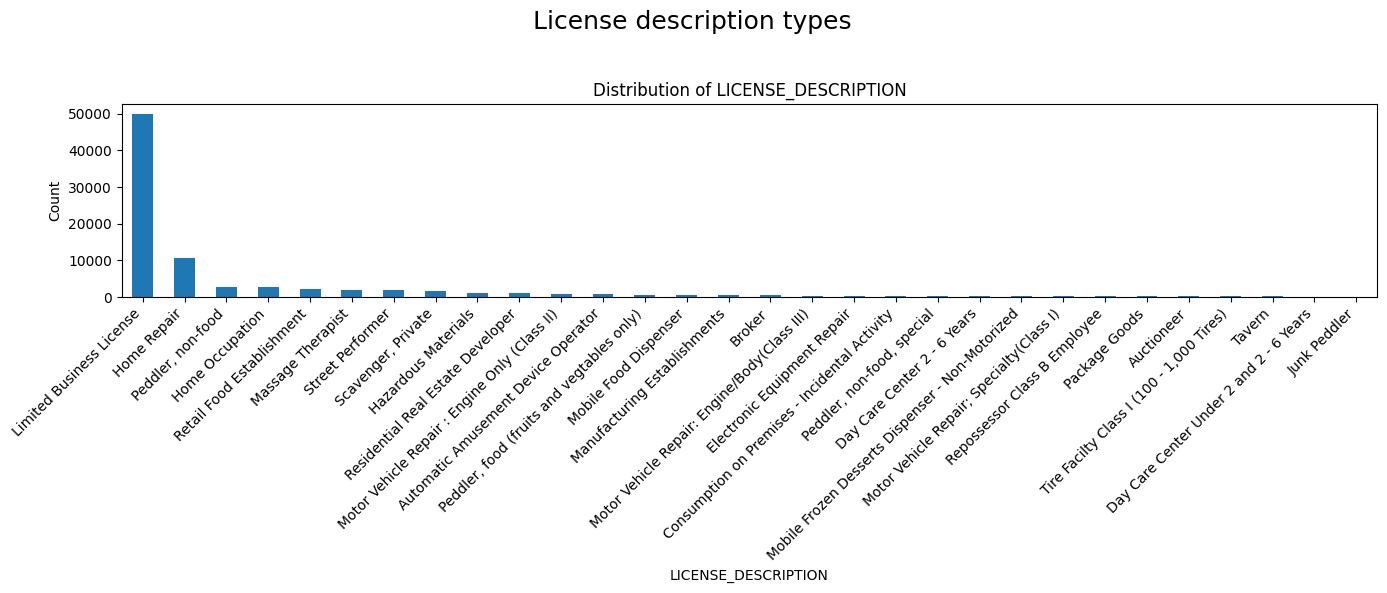

In [ ]:

col = 'LICENSE_DESCRIPTION'

fig, ax = plt.subplots(figsize=(14, 6))
fig.suptitle('License description types', fontsize=18)

df[col].value_counts().head(30).plot(kind='bar', ax=ax)

ax.set_title(f'Distribution of {col}')
ax.set_xlabel(col)
ax.set_ylabel('Count')

plt.xticks(rotation=45, ha='right')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


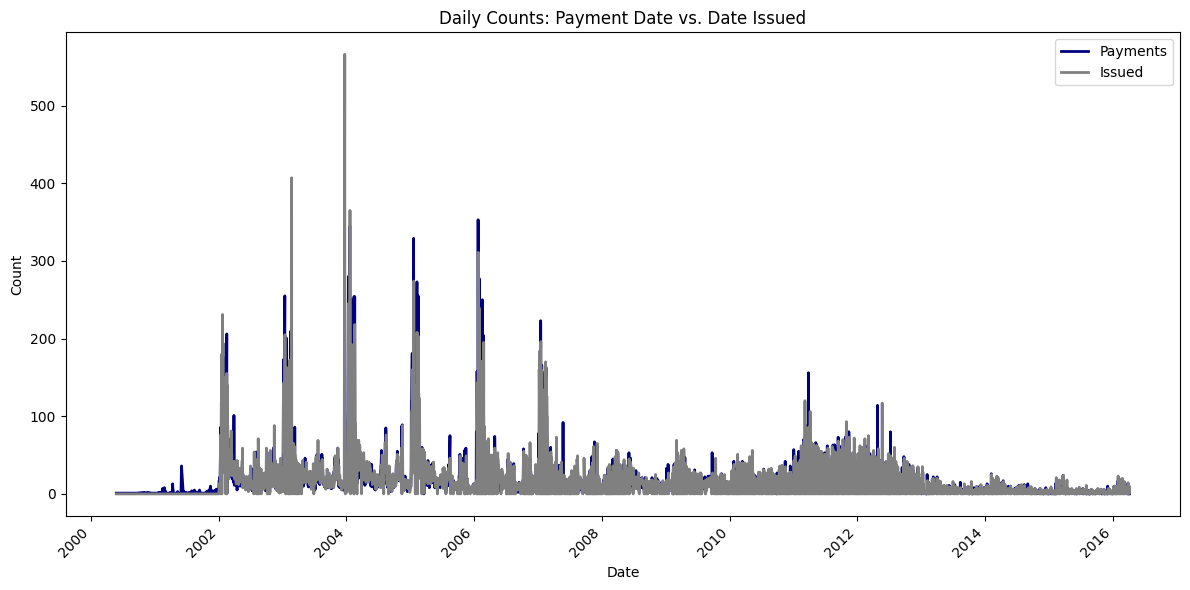

In [ ]:

for col in ['PAYMENT_DATE', 'DATE_ISSUED']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

pay_counts = df.groupby(df['PAYMENT_DATE'].dt.date).size()
iss_counts = df.groupby(df['DATE_ISSUED'].dt.date).size()

all_dates = pay_counts.index.union(iss_counts.index)
pay_counts = pay_counts.reindex(all_dates, fill_value=0)
iss_counts = iss_counts.reindex(all_dates, fill_value=0)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(all_dates, pay_counts, label='Payments', linewidth=2, color='navy')
ax.plot(all_dates, iss_counts, label='Issued', linewidth=2, color='grey')

ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title('Daily Counts: Payment Date vs. Date Issued')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


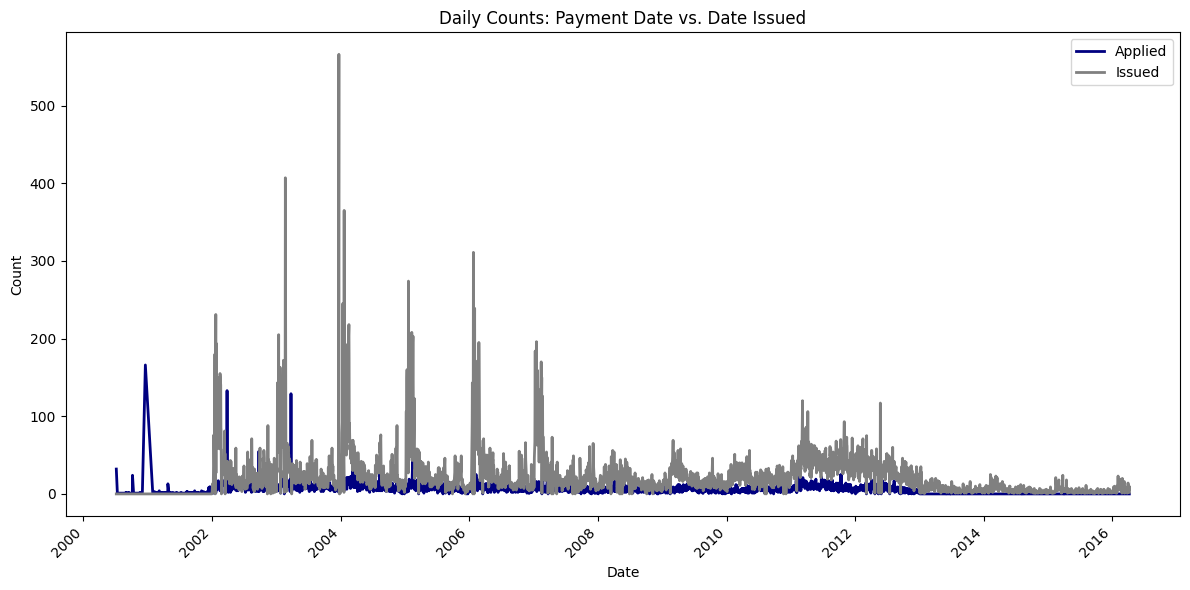

In [ ]:

for col in ['APPLICATION_CREATED_DATE', 'DATE_ISSUED']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

pay_counts = df.groupby(df['APPLICATION_CREATED_DATE'].dt.date).size()
iss_counts = df.groupby(df['DATE_ISSUED'].dt.date).size()

all_dates = pay_counts.index.union(iss_counts.index)
pay_counts = pay_counts.reindex(all_dates, fill_value=0)
iss_counts = iss_counts.reindex(all_dates, fill_value=0)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(all_dates, pay_counts, label='Applied', linewidth=2, color='navy')
ax.plot(all_dates, iss_counts, label='Issued', linewidth=2, color='grey')

ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title('Daily Counts: Payment Date vs. Date Issued')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Data Prep

In [ ]:
na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts.head(20))


,0
SSA,76446
APPLICATION_CREATED_DATE,64660
PRECINCT,56701
LICENSE_STATUS_CHANGE_DATE,55400
POLICE_DISTRICT,54012
WARD,49701
WARD_PRECINCT,49700
LONGITUDE,47246
LOCATION,47246
LATITUDE,47246


In [ ]:
uniques = df.nunique().sort_values()
display(uniques.head(15))



,0
LICENSE_APPROVED_FOR_ISSUANCE,1
APPLICATION_REQUIREMENTS_COMPLETE,1
CONDITIONAL_APPROVAL,2
APPLICATION_TYPE,5
LICENSE_STATUS,5
POLICE_DISTRICT,28
WARD,50
SSA,53
STATE,54
PRECINCT,76


# 4. Preprecessing


* **Type coercion & date parsing**

  * Cast date strings (e.g. `APPLICATION_CREATED_DATE`, `PAYMENT_DATE`) to `datetime64[ns]` for fast vectorized arithmetic.
  * Convert numeric IDs (e.g. `ACCOUNT_NUMBER`, `LICENSE_NUMBER`) to string dtype so they’re treated as categorical keys.&#x20;

* **Missing-value strategy**

  * For high-missing categorical fields (e.g. `SSA`, `WARD`), add “\_MISSING” flags and fill with `"Unknown"` so models can learn any “missingness” signal.
  * Back-fill lone missing `DOING_BUSINESS_AS_NAME` from `LEGAL_NAME` to preserve identity.&#x20;

* **Spatial imputation via clustering**

  * Fit K-Means (n=50) on existing `(LATITUDE, LONGITUDE)` to form spatial clusters.
  * Impute missing coords by assigning to nearest cluster’s centroid—captures local geography better than global means.&#x20;

* **Derived temporal & spatial features**

  * **Time deltas:** e.g. `DAYS_TO_PAYMENT`, `DAYS_TO_ISSUE`, `TERM_LENGTH_DAYS` quantify process latency and durations.
  * **Date parts:** extract year, month, weekday to expose seasonality without raw timestamps.
  * **Haversine distance:** compute distance to city centroid—encodes business density/regulatory gradients.&#x20;

* **Low-variance pruning**

  * Use `VarianceThreshold` to remove near-constant numeric features, reducing noise and speeding training.&#x20;


In [ ]:
na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts.head(20))

NameError: name 'df' is not defined

In [ ]:
import pandas as pd


# handle high missing cat columns
cat_high_missing = ['SSA', 'PRECINCT', 'POLICE_DISTRICT', 'WARD', 'WARD_PRECINCT']
for col in cat_high_missing:
    df[f'{col}_MISSING'] = df[col].isna().astype(int)

    if isinstance(df[col].dtype, pd.CategoricalDtype):
        if 'Unknown' not in df[col].cat.categories:
            df[col] = df[col].cat.add_categories(['Unknown'])
        df[col] = df[col].fillna('Unknown')
    else:
        df[col] = df[col].fillna('Unknown')

In [ ]:
#Convert and flag
date_cols = [
    'LICENSE_STATUS_CHANGE_DATE',
    'PAYMENT_DATE',
    'LICENSE_TERM_START_DATE',
    'LICENSE_TERM_EXPIRATION_DATE',
    'APPLICATION_CREATED_DATE'
]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[f'{col}_MISSING'] = df[col].isna().astype(int)

In [ ]:
#Handle PAYMENT_DATE
df = df[df['PAYMENT_DATE_MISSING'] == 0].copy()

In [ ]:
# LICENSE_TERM_START/EXPIRATION_DATE
df = df.dropna(
    subset=['LICENSE_TERM_START_DATE', 'LICENSE_TERM_EXPIRATION_DATE']
).copy()

In [ ]:

#Convert to numeric
df['LATITUDE']  = pd.to_numeric(df['LATITUDE'],  errors='coerce')
df['LONGITUDE'] = pd.to_numeric(df['LONGITUDE'], errors='coerce')


In [ ]:
#Fill missing
df['DOING_BUSINESS_AS_NAME'] = df['DOING_BUSINESS_AS_NAME'].fillna(
    df['LEGAL_NAME']
)

In [ ]:
from sklearn.cluster import KMeans

# Fit KMeans
valid = df[['LATITUDE','LONGITUDE']].dropna()
kmeans = KMeans(n_clusters=50, random_state=42).fit(valid)

# Assign to nearest cluster
df['cluster'] = kmeans.predict(
    df[['LATITUDE','LONGITUDE']].fillna(0)  # placeholder zeros won’t matter much for clustering
)

# Fill missing (with cluster centers)
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['LATITUDE','LONGITUDE'])
df[['LATITUDE','LONGITUDE']] = df.apply(
    lambda row: centers.loc[row['cluster']]
                if pd.isna(row['LATITUDE']) else row[['LATITUDE','LONGITUDE']],
    axis=1, result_type='expand'
)


In [ ]:
na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts.head(10))

,0
APPLICATION_CREATED_DATE,63544
LICENSE_STATUS_CHANGE_DATE,54879
LOCATION,46525
SITE_NUMBER,0
LEGAL_NAME,0
DOING_BUSINESS_AS_NAME,0
ADDRESS,0
CITY,0
ID,0
LICENSE_ID,0


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(df.head())

,ID,LICENSE_ID,ACCOUNT_NUMBER,SITE_NUMBER,LEGAL_NAME,DOING_BUSINESS_AS_NAME,ADDRESS,CITY,STATE,ZIP_CODE,WARD,PRECINCT,WARD_PRECINCT,POLICE_DISTRICT,LICENSE_CODE,LICENSE_DESCRIPTION,LICENSE_NUMBER,APPLICATION_TYPE,APPLICATION_CREATED_DATE,APPLICATION_REQUIREMENTS_COMPLETE,PAYMENT_DATE,CONDITIONAL_APPROVAL,LICENSE_TERM_START_DATE,LICENSE_TERM_EXPIRATION_DATE,LICENSE_APPROVED_FOR_ISSUANCE,DATE_ISSUED,LICENSE_STATUS_CHANGE_DATE,SSA,LATITUDE,LONGITUDE,LOCATION,LICENSE_STATUS,SSA_MISSING,PRECINCT_MISSING,POLICE_DISTRICT_MISSING,WARD_MISSING,WARD_PRECINCT_MISSING,LICENSE_STATUS_CHANGE_DATE_MISSING,PAYMENT_DATE_MISSING,LICENSE_TERM_START_DATE_MISSING,LICENSE_TERM_EXPIRATION_DATE_MISSING,APPLICATION_CREATED_DATE_MISSING,cluster
0,35342-20020816,1256593,32811,1,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,2625 S CENTRAL PARK AVE 1,CHICAGO,IL,60623.0,22.0,28.0,22-28,10.0,1010,Limited Business License,35342.0,RENEW,NaT,False,2002-08-21,False,2002-08-16,2003-08-15,False,2006-04-11,NaT,25.0,41.843613,-87.714618,"{'latitude': '41.843612879431845', 'longitude': '-87.71461847216574', 'needs_recoding': False, 'human_address': '{""address"":"""",""city"":"""",""state"":"""",""zip"":""""}'}",AAI,0,0,0,0,0,1,0,0,0,1,45
1,1358463-20051116,1639294,262311,29,"ISLA TROPICAL, INC.",ISLA TROPICAL,2825 W MONTROSE AVE,CHICAGO,IL,60618,33.0,23.0,33-23,17.0,1315,Mobile Food Dispenser,1358463.0,RENEW,NaT,False,2005-11-03,False,2005-11-16,2006-11-15,False,2006-06-12,2006-06-15,60.0,41.961132,-87.699626,"{'latitude': '41.96113244107215', 'longitude': '-87.69962604438346', 'needs_recoding': False, 'human_address': '{""address"":"""",""city"":"""",""state"":"""",""zip"":""""}'}",AAC,0,0,0,0,0,0,0,0,0,1,23
2,1980233-20090722,1980233,345008,1,DJS REMODELING,"DJS REMODELING, INC.",1605 CLAVEY RD 1,HIGHLAND,IL,60035,Unknown,Unknown,Unknown,Unknown,1011,Home Repair,1980233.0,ISSUE,2009-06-29,False,2009-07-22,False,2009-07-22,2011-07-15,False,2009-07-22,NaT,Unknown,41.704217,-87.543410,NaN,AAI,1,1,1,1,1,1,0,0,0,0,28
3,1476582-20040211,1476582,273121,1,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,8 NORTH TRAIL,LEMONT,IL,60439,Unknown,Unknown,Unknown,Unknown,1010,Limited Business License,1476582.0,ISSUE,2004-02-10,False,2004-02-10,False,2004-02-11,2005-02-15,False,2004-02-11,NaT,Unknown,41.704217,-87.543410,NaN,AAI,1,1,1,1,1,1,0,0,0,0,28
4,1141408-20080516,1896750,213785,1,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,4081 JOSEPH DR,WAUKEGAN,IL,60087,Unknown,Unknown,Unknown,Unknown,1010,Limited Business License,1141408.0,RENEW,NaT,False,2008-06-04,False,2008-05-16,2010-05-15,False,2008-06-05,NaT,Unknown,41.704217,-87.543410,NaN,AAI,1,1,1,1,1,1,0,0,0,1,28


#5. Feature Engineering


- **Temporal Delta Features**  
  - `DAYS_TO_PAYMENT` = (payment date – application creation date in days); missing → –1  
  - `TERM_LENGTH_DAYS` = (expiration date – start date); missing → –1  
  - `DAYS_TO_ISSUE` = (issuance date – application date); missing → –1

* **Coerce to `datetime64[ns]`**
  Ensures efficient, vectorized date math (via `.dt`) and avoids parsing errors.

* **Derive duration deltas**

  * E.g. days-to-payment (`payment_date − application_date`), term length (`expiry_date − start_date`), days-to-issue
  * Fill missing with sentinel (e.g. −1) and cast to integer for seamless normalization and tree-model ingestion.

* **Extract calendar features**
  Year, month and weekday from timestamps as low-cardinality integer categories—captures seasonality without heavy one-hot overhead.

* **Compute haversine distance**
  Great-circle distance from record’s lat/long to the city-center mean; missing/invalid → sentinel. Encodes spatial clustering in one scalar.

* **Snapshot engineered DataFrame**
  Copy augmented `df` (e.g. `df1 = df.copy()`) to isolate feature-engineered state for safe rollback and parallel experiments.




In [ ]:
import numpy as np

for col in ['APPLICATION_CREATED_DATE', 'PAYMENT_DATE',
            'LICENSE_TERM_START_DATE', 'LICENSE_TERM_EXPIRATION_DATE',
            'DATE_ISSUED']:
    df[col] = pd.to_datetime(df[col], errors='coerce')


In [ ]:
#Time‐based deltas
df['DAYS_TO_PAYMENT'] = (df['PAYMENT_DATE'] - df['APPLICATION_CREATED_DATE']) \
    .dt.days.fillna(-1).astype(int)
df['TERM_LENGTH_DAYS'] = (df['LICENSE_TERM_EXPIRATION_DATE'] - df['LICENSE_TERM_START_DATE']) \
    .dt.days.fillna(-1).astype(int)
df['DAYS_TO_ISSUE'] = (df['DATE_ISSUED'] - df['APPLICATION_CREATED_DATE']) \
    .dt.days.fillna(-1).astype(int)

In [ ]:
# Application date parts
df['APP_YEAR']  = df['APPLICATION_CREATED_DATE'].dt.year.fillna(0).astype(int)
df['APP_MONTH'] = df['APPLICATION_CREATED_DATE'].dt.month.fillna(0).astype(int)
df['APP_DOW']   = df['APPLICATION_CREATED_DATE'].dt.dayofweek.fillna(0).astype(int)



In [ ]:
#Distance to city center
city_lat = df['LATITUDE'].mean()
city_lng = df['LONGITUDE'].mean()
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    φ1, φ2 = np.radians(lat1), np.radians(lat2)
    Δφ = φ2 - φ1
    Δλ = np.radians(lon2 - lon1)
    a = np.sin(Δφ/2)**2 + np.cos(φ1)*np.cos(φ2)*np.sin(Δλ/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

df['DIST_TO_CENTER_KM'] = haversine(df['LATITUDE'], df['LONGITUDE'],
                                    city_lat, city_lng) \
    .fillna(-1)

In [ ]:
df1 = df.copy()

In [ ]:
df1.columns

Index(['ID', 'LICENSE_ID', 'ACCOUNT_NUMBER', 'SITE_NUMBER', 'LEGAL_NAME',
       'DOING_BUSINESS_AS_NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP_CODE',
       'WARD', 'PRECINCT', 'WARD_PRECINCT', 'POLICE_DISTRICT', 'LICENSE_CODE',
       'LICENSE_DESCRIPTION', 'LICENSE_NUMBER', 'APPLICATION_TYPE',
       'APPLICATION_CREATED_DATE', 'APPLICATION_REQUIREMENTS_COMPLETE',
       'PAYMENT_DATE', 'CONDITIONAL_APPROVAL', 'LICENSE_TERM_START_DATE',
       'LICENSE_TERM_EXPIRATION_DATE', 'LICENSE_APPROVED_FOR_ISSUANCE',
       'DATE_ISSUED', 'LICENSE_STATUS_CHANGE_DATE', 'SSA', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'LICENSE_STATUS', 'SSA_MISSING',
       'PRECINCT_MISSING', 'POLICE_DISTRICT_MISSING', 'WARD_MISSING',
       'WARD_PRECINCT_MISSING', 'LICENSE_STATUS_CHANGE_DATE_MISSING',
       'PAYMENT_DATE_MISSING', 'LICENSE_TERM_START_DATE_MISSING',
       'LICENSE_TERM_EXPIRATION_DATE_MISSING',
       'APPLICATION_CREATED_DATE_MISSING', 'cluster', 'DAYS_TO_PAYMENT',
       'TERM_LENGTH_DAYS',

Why I Am Dropping These Columns

| Column                                                      | Keep / Drop / Transform | Rationale                                                                               |
| ----------------------------------------------------------- | ----------------------- | --------------------------------------------------------------------------------------- |
| ID                                                          | Drop                    | Unique identifier only – no predictive value.                                           |
| LICENSE\_ID                                                 | Drop                    | Same as ID (one-to-one) and numeric; no signal.                                         |
| ACCOUNT\_NUMBER                                             | Drop                    | Applicant account ID; high cardinality, no predictive signal.                           |
| SITE\_NUMBER                                                | Drop                    | Internal site code; again high cardinality, low signal.                                 |
| LEGAL\_NAME                                                 | Drop                    | Business name – effectively a textual ID, not meaningful for classification.            |
| DOING\_BUSINESS\_AS\_NAME                                   | Drop                    | Same as above.                                                                          |
| ADDRESS                                                     | Drop                    | Free-form address string; too granular. We’ll keep ZIP, lat/long instead.               |
| CITY, STATE                                                 | Drop                    | All entries are “Chicago, IL”—no variation.                                             |
| ZIP\_CODE                                                   | Keep                    | Captures neighborhood effects; fill missing and one-hot or embed.                       |
| WARD, PRECINCT, SSA                                         | Keep                    | Administrative boundaries – potentially informative.                                    |
| WARD\_PRECINCT                                              | Drop                    | Redundant combination of WARD + PRECINCT.                                               |
| POLICE\_DISTRICT                                            | Keep                    | Another spatial zone; may correlate with enforcement patterns.                          |
| LICENSE\_CODE, LICENSE\_DESCRIPTION                         | Transform               | Keep LICENSE\_CODE (numeric); drop text description or map codes to groups if too many. |
| LICENSE\_NUMBER                                             | Drop                    | Sequential license ID – no predictive power.                                            |
| APPLICATION\_TYPE                                           | Keep                    | “RENEW” vs. “ISSUE” vs. “NEW” etc. important process differences.                       |
| APPLICATION\_CREATED\_DATE                                  | Transform               | Derive year/month/day-of-week; drop raw afterwards.                                     |
| APPLICATION\_REQUIREMENTS\_COMPLETE                         | Keep                    | Binary flag once cleaned (complete/incomplete).                                         |
| PAYMENT\_DATE                                               | Transform               | Derive lag from created date; drop raw after.                                           |
| CONDITIONAL\_APPROVAL                                       | Keep                    | Binary flag.                                                                            |
| LICENSE\_TERM\_START\_DATE, LICENSE\_TERM\_EXPIRATION\_DATE | Transform               | Derive term length; drop raw dates.                                                     |
| LICENSE\_APPROVED\_FOR\_ISSUANCE                            | Drop                    | Duplicate of LICENSE\_STATUS == “AAI”?                                                  |
| DATE\_ISSUED, LICENSE\_STATUS\_CHANGE\_DATE                 | Drop (for training)     | These occur at/after final decision; leakage if predicting status before issuance.      |
| LATITUDE, LONGITUDE                                         | Keep (optional)         | If you want precise geospatial features. Could cluster.                                 |
| LOCATION                                                    | Drop                    | Nested dict of lat/long & address junk.                                                 |
| LICENSE\_STATUS (target)                                    | Keep                    | Your label.                                                                             |



In [ ]:
to_drop = [
    # IDs & identifiers
    'ID', 'LICENSE_ID', 'ACCOUNT_NUMBER', 'SITE_NUMBER',

    # Free form text / address / name fields
    'LEGAL_NAME', 'DOING_BUSINESS_AS_NAME',
    'ADDRESS', 'CITY', 'STATE', 'LOCATION',

    # Redundant geography combos
    'WARD_PRECINCT',

    # License codes/descriptions
    'LICENSE_DESCRIPTION', 'LICENSE_NUMBER',

    # leakage
    'LICENSE_APPROVED_FOR_ISSUANCE',
    'DATE_ISSUED', 'LICENSE_STATUS_CHANGE_DATE',

    # Raw date fields (replaced )
    'APPLICATION_CREATED_DATE', 'PAYMENT_DATE',
    'LICENSE_TERM_START_DATE', 'LICENSE_TERM_EXPIRATION_DATE',

    # Raw cluster ID (one-hot encoded it already)
    'cluster',

    # One-off missing flag columns (i have captured missing via -1 in deltas)
    'SSA_MISSING', 'PRECINCT_MISSING', 'POLICE_DISTRICT_MISSING',
    'WARD_MISSING', 'WARD_PRECINCT_MISSING',
    'LICENSE_STATUS_CHANGE_DATE_MISSING',
    'PAYMENT_DATE_MISSING',
    'LICENSE_TERM_START_DATE_MISSING',
    'LICENSE_TERM_EXPIRATION_DATE_MISSING',
    'APPLICATION_CREATED_DATE_MISSING',
]
df1.drop(columns=to_drop, inplace=True)


In [ ]:
df1.columns

Index(['ZIP_CODE', 'WARD', 'PRECINCT', 'POLICE_DISTRICT', 'LICENSE_CODE',
       'APPLICATION_TYPE', 'APPLICATION_REQUIREMENTS_COMPLETE',
       'CONDITIONAL_APPROVAL', 'SSA', 'LATITUDE', 'LONGITUDE',
       'LICENSE_STATUS', 'DAYS_TO_PAYMENT', 'TERM_LENGTH_DAYS',
       'DAYS_TO_ISSUE', 'APP_YEAR', 'APP_MONTH', 'APP_DOW',
       'DIST_TO_CENTER_KM'],
      dtype='object')

In [ ]:
df1.dtypes

,0
ZIP_CODE,object
WARD,category
PRECINCT,category
POLICE_DISTRICT,category
LICENSE_CODE,category
APPLICATION_TYPE,object
APPLICATION_REQUIREMENTS_COMPLETE,bool
CONDITIONAL_APPROVAL,bool
SSA,category
LATITUDE,float64


In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

save_dir = '/content/drive/MyDrive/colab_data'
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, 'df1.pkl')
df1.to_pickle(save_path)

print(f"df1 saved to {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
df1 saved to /content/drive/MyDrive/colab_data/df1.pkl


# 6. Feature Selection


- **Correlation Analysis**  
  - Computed Pearson correlation matrix for all numeric and engineered features; visualized via heatmap to detect multicollinearity.

- **Variance Thresholding**  
  - Sorted feature variances; selected threshold (e.g. 0.01) under which features add little information.  
  - Applied `VarianceThreshold(threshold=0.01)`, removed low-variance features.  
  - Recorded final feature list (support=True) and count of retained features.

- **Dimensionality Reduction**  
  - performed `PCA` for low-dimensional projection to reduce noise (bias) in the feature selection.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

y = df1['LICENSE_STATUS']
X = df1.drop(columns=['LICENSE_STATUS'])

## Clustering and Variance Reduction

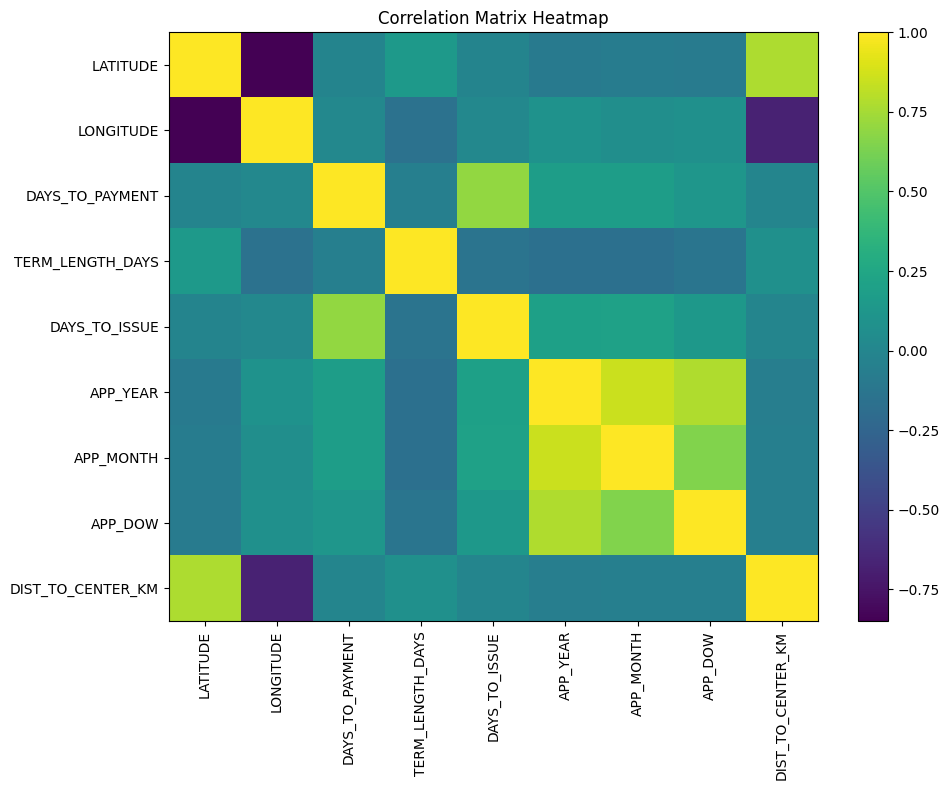

In [ ]:
import matplotlib.pyplot as plt

#correlation on all numeric columns

numeric_cols = df1.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df1[numeric_cols].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
X_num = X.select_dtypes(include=[np.number]).copy()
print("Numeric features count:", X_num.shape[1])

#Correlation filtering
corr_matrix = X_num.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.90)]
X_corr = X_num.drop(columns=to_drop)
print(f"Dropped {len(to_drop)} features with corr > 0.90")


Numeric features count: 9
Dropped 0 features with corr > 0.90


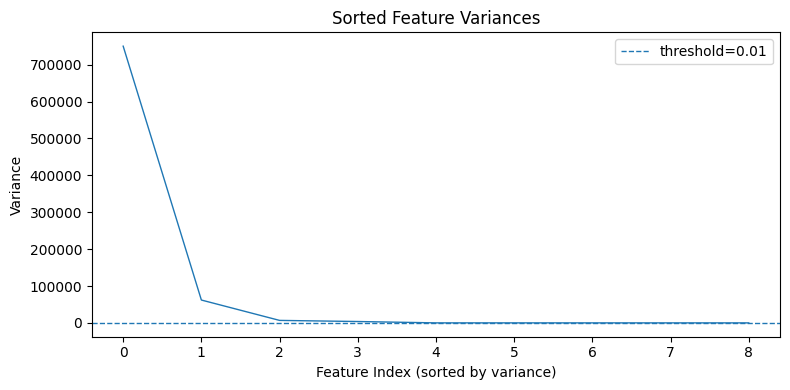

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold


#Visualize variances
variances_sorted = X_corr.var().sort_values(ascending=False)
var_thresh = 0.01

plt.figure(figsize=(8,4))
plt.plot(variances_sorted.values, linewidth=1)
plt.axhline(y=var_thresh, linestyle='--', linewidth=1, label=f"threshold={var_thresh}")
plt.title("Sorted Feature Variances")
plt.xlabel("Feature Index (sorted by variance)")
plt.ylabel("Variance")
plt.legend()
plt.tight_layout()
plt.show()




In [ ]:
# VarianceThreshold
selector = VarianceThreshold(threshold=var_thresh)
X_var_array = selector.fit_transform(X_corr)

mask = selector.get_support()
selected_features = X_corr.columns[mask]
X_var = pd.DataFrame(X_var_array, columns=selected_features, index=X_corr.index)
print(f"Kept {len(selected_features)} features with variance > {var_thresh}")

Kept 8 features with variance > 0.01
